In [1]:
!pip install --ignore-installed spark-nlp

import sparknlp
!pip install wordcloud
!pip install nltk

  Using cached spark_nlp-2.5.3-py2.py3-none-any.whl (123 kB)


In [2]:
from pyspark.sql.functions import *
import pyspark.sql.types as ty
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sparknlp.base import *
from sparknlp.annotator import *
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.sql import DataFrame
from functools import reduce

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from pyspark.sql import SparkSession
def start():
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("yarn") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.5.1") 
        
    return builder.getOrCreate()
spark=start()
spark.conf.set("spark.sql.shuffle.partitions",400)
#spark.conf.set("spark.executor.instances",4)
#spark.conf.set("spark.dynamicAllocation.enabled","True")
spark.conf.set("spark.executor.memory","6.9g")
spark.conf.set("spark.num.executors",30)
spark.conf.set("spark.executor.cores",1)
spark.conf.set("spark.sql.files.ignoreCorruptFiles", "true")

In [4]:
spark

In [5]:
flat_count=udf(
    lambda x:dict(Counter(x)),
    ty.MapType(ty.StringType(),ty.IntegerType())) 

def matcher(l,l1):
    l2=[]
    for i in l:
      if i in l1:
            l2.append(i)#extend(seg.segment(i))
    return l2

def matcher_udf(term_list):
        return udf(lambda row : matcher(row,term_list),ty.ArrayType(ty.StringType()))

def token_to_text(x):
    s=""
    for i in x:
        i=i+" "
        s=s + i
    return s
token_to_text_udf=udf(lambda x : token_to_text(x),ty.StringType())

def generate_wordcloud(l):
    #l=list(l)
    total_text=" ".join(l)
    wordcloud = WordCloud(background_color="black").generate(total_text)
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def generate_wordcloud_df(df):
    word_df=df.select(token_to_text_udf("no_stop_lemmatized.result").alias("cleaned_text"))
    text_l=list(word_df.select("cleaned_text").toPandas()["cleaned_text"])
    return text_l

In [6]:
spark.version

'2.4.5'

In [7]:

doc_assembled=DocumentAssembler().setInputCol("full_text").setOutputCol("document")
tokenizer = Tokenizer() \
     .setInputCols(['document']) \
     .setOutputCol('tokenized')\
     #.setContextChars(["@"])
emojis=[u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"]
#print(type(emojis))

others=["(https:?[^\s]+)|(www\.[^\s]+)","@[^\s]+","\n","[^A-Za-z0-9]","[Rr][Tt]","#"]
#others.append(emojis)
for i in emojis:
    others.append(i)
others

normalizer=Normalizer()\
        .setInputCols("tokenized")\
        .setOutputCol("normalized")\
        .setCleanupPatterns(others)\
        .setLowercase(True)
ngrams_cum = NGramGenerator() \
            .setInputCols(["no_stop_lemmatized"]) \
            .setOutputCol("ngrams") \
            .setN(3) \
            .setEnableCumulative(True)

lemmatizer = LemmatizerModel.pretrained() \
     .setInputCols(['normalized']) \
     .setOutputCol('lemmatized')

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [8]:

#from nltk.corpus import stopwords
#eng_stopwords = stopwords.words('english')

eng_stopwords = stopwords.words('english')

stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(['lemmatized']) \
     .setCaseSensitive(False)\
     .setOutputCol('no_stop_lemmatized') \
     .setStopWords(eng_stopwords)

finisher = Finisher() \
    .setInputCols(['no_stop_lemmatized']) \
    .setCleanAnnotations(False)


In [9]:
pipeline=Pipeline()\
        .setStages([
        doc_assembled,
        tokenizer,
        normalizer,
        lemmatizer,
        stopwords_cleaner,
        ngrams_cum,
        finisher
        ])

In [10]:
def extract_data(path_list):
    df_list=[]
    for i in path_list:
        #df=spark.read.json(i)
        df=spark.read.orc(i)
        df=df.filter(df.lang=='en')
        df=df.withColumn('created_at', from_unixtime(unix_timestamp("created_at", "EEE MMM dd HH:mm:ss ZZZZ yyyy"), "yyyy-MM-dd"))
        df=pipeline.fit(df).transform(df)
        df=df.select("id","created_at","no_stop_lemmatized.result","full_text","retweet_count","geo","coordinates","ngrams")
        df_list.append(df)
    data=reduce(DataFrame.unionAll,df_list)
    
    return data

In [29]:
paths=["gs://joel_twitter_data/data/2020-01/*-12.jsonl.gz","gs://joel_twitter_data/data/2020-02/*-12.jsonl.gz","gs://joel_twitter_data/data/2020-03/*-12.jsonl.gz","gs://joel_twitter_data/data/2020-04/*-12.jsonl.gz","gs://joel_twitter_data/data/2020-05/*-12.jsonl.gz"]
paths1=["gs://joel_twitter_data/data/2020-01/*-13.jsonl.gz","gs://joel_twitter_data/data/2020-02/*-13.jsonl.gz","gs://joel_twitter_data/data/2020-03/*-13.jsonl.gz","gs://joel_twitter_data/data/2020-04/*-13.jsonl.gz","gs://joel_twitter_data/data/2020-05/*-13.jsonl.gz"]
paths2=["gs://joel_twitter_data/data/2020-01/*-11.jsonl.gz","gs://joel_twitter_data/data/2020-02/*-11.jsonl.gz","gs://joel_twitter_data/data/2020-03/*-11.jsonl.gz","gs://joel_twitter_data/data/2020-04/*-11.jsonl.gz","gs://joel_twitter_data/data/2020-05/*-11.jsonl.gz"]
paths3=["gs://joel_twitter_data/data/2020-01/*-14.jsonl.gz","gs://joel_twitter_data/data/2020-02/*-14.jsonl.gz","gs://joel_twitter_data/data/2020-03/*-14.jsonl.gz","gs://joel_twitter_data/data/2020-04/*-14.jsonl.gz","gs://joel_twitter_data/data/2020-05/*-14.jsonl.gz"]

In [ ]:
data1=extract_data(paths1)
data2=extract_data(paths2)
data3=extract_data(paths3)
data=extract_data(paths)
data_l=[data,data1,data2,data3]
data=reduce(DataFrame.unionAll,data_l)

In [12]:
#data=extract_data(paths_full)

In [13]:
data

DataFrame[id: bigint, created_at: string, result: array<string>, full_text: string, retweet_count: bigint, geo: struct<coordinates:array<double>,type:string>, coordinates: struct<coordinates:array<double>,type:string>, ngrams: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>]

In [ ]:
data.count()

78363607

In [ ]:
data.select("created_at").distinct().collect()

[Row(created_at='2020-04-15'),
 Row(created_at='2020-04-13'),
 Row(created_at='2020-02-26'),
 Row(created_at='2020-04-12'),
 Row(created_at='2020-02-13'),
 Row(created_at='2020-02-07'),
 Row(created_at='2020-04-20'),
 Row(created_at='2020-03-19'),
 Row(created_at='2020-02-27'),
 Row(created_at='2020-02-16'),
 Row(created_at='2020-02-21'),
 Row(created_at='2020-01-22'),
 Row(created_at='2020-04-01'),
 Row(created_at='2020-04-22'),
 Row(created_at='2020-02-29'),
 Row(created_at='2020-03-16'),
 Row(created_at='2020-01-24'),
 Row(created_at='2020-04-03'),
 Row(created_at='2020-04-19'),
 Row(created_at='2020-03-03'),
 Row(created_at='2020-04-11'),
 Row(created_at='2020-05-05'),
 Row(created_at='2020-04-06'),
 Row(created_at='2020-03-09'),
 Row(created_at='2020-03-06'),
 Row(created_at='2020-03-26'),
 Row(created_at='2020-05-04'),
 Row(created_at='2020-03-29'),
 Row(created_at='2020-02-04'),
 Row(created_at='2020-02-05'),
 Row(created_at='2020-03-05'),
 Row(created_at='2020-03-02'),
 Row(cre

# Frequent Terms

In [15]:
data

DataFrame[id: bigint, created_at: string, result: array<string>, full_text: string, retweet_count: bigint, geo: struct<coordinates:array<double>,type:string>, coordinates: struct<coordinates:array<double>,type:string>, ngrams: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>]

In [12]:
data.count()

11191922

In [ ]:
t1=data.select("id","created_at","ngrams",explode(col("ngrams.result")).alias("word"))#.show()
#t1.show(20)
#df_count=t1.agg(countDistinct("word"))
df_count=t1.select("word").distinct().count()
#df_count=df_count.cache()

In [18]:
df_count

DataFrame[count(DISTINCT word): bigint]

In [ ]:
df_count.orderBy(desc("count(DISTINCT word)")).take(150)

In [13]:
terms=spark.read.text("gs://joel_twitter_data/notebooks/jupyter/outbreak.txt")
terms=terms.toPandas()["value"]

terms=list(terms)
#new=["psa","facial mask","psa facial mask","wuhan","china"]
#terms.extend(new)
#terms
terms=list(map(lambda x:x.lower(),terms))
#li=[]

#for i in l:
new=["psa","psa facial mask","wuhanvirus","chinavirus","wuhan","china","facial mask","coronavirus outbreak","spread","wuhan","runny nose","diarrhoea","flu","stay home","social distance","covid","lockdown"
     "self-quarantine","community transmission","super spreader","zoonotic disease","self-isolate","self isolation"]

#    print(segment(i))
terms.extend(new)
#li
#segment("hello")
terms
terms[2]="covid19"

terms.append("covid 19")
terms.append("merscov")
terms.append("sarscov")
terms.append("coronavirus case")
terms

['sars cov 2  ',
 'coronavirus ',
 'covid19',
 'quarantine ',
 'self isolating ',
 'stay at home ',
 'shelter in place',
 'middle east respiratory syndrome ',
 'mers cov ',
 'severe acute respiratory syndrome ',
 'sars cov ',
 'community spread ',
 'public health emergency ',
 'outbreak ',
 'epidemic ',
 'droplet transmission ',
 'home isolation ',
 'viral shedding',
 'novel coronavirus',
 'symptomatic',
 'shortness of breath',
 'sore throat',
 'headache',
 'respiratory illness',
 'respiratory virus',
 'tasteless',
 'fever',
 'fever 100',
 'fever 38c',
 'rhinorrhea',
 'dyspnea',
 'nausea',
 'antigen test',
 'corona virus',
 'corona',
 'pandemic',
 'cough',
 'tiredness',
 'chest pain',
 'loss of taste',
 'loss of smell',
 'psa',
 'psa facial mask',
 'wuhanvirus',
 'chinavirus',
 'wuhan',
 'china',
 'facial mask',
 'coronavirus outbreak',
 'spread',
 'wuhan',
 'runny nose',
 'diarrhoea',
 'flu',
 'stay home',
 'social distance',
 'covid',
 'lockdownself-quarantine',
 'community transmiss

In [19]:
t1=data.select("id","created_at","ngrams")#,explode(col("ngrams.result")).alias("word"))#.show()

t1=t1.withColumn("matched_word_list", matcher_udf(terms)(col("ngrams.result")))
#     .withColumn("count",flat_count(""))
t1=t1.withColumn("dict",flat_count("matched_word_list"))
t2=t1.select("created_at","id","dict",explode(col("dict")).alias("term","frequency"))
#t2.show(20)
t2
k=t2.groupBy("term").agg(sum("frequency"))#.show()
k.cache()

In [ ]:
freq_terms=k.orderBy(desc("sum(frequency)")).toPandas()
freq_terms

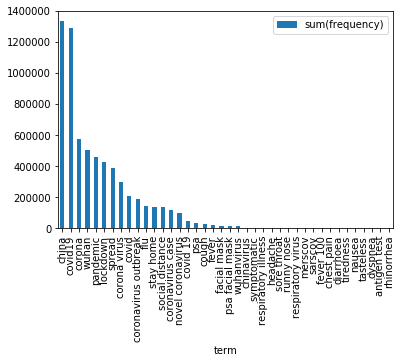

In [23]:
import pandas as pd
freq_terms.plot.bar(x='term',y='sum(frequency)')

# Outbreak Term Metrics

In [17]:
freq_Terms=list(freq_terms[:30]["term"])

In [18]:
t1=data.select("id","created_at","ngrams")#,explode(col("ngrams.result")).alias("word"))#.show()

t1=t1.withColumn("matched_word_list", matcher_udf(freq_Terms)(col("ngrams.result")))
#     .withColumn("count",flat_count(""))
t1=t1.withColumn("dict",flat_count("matched_word_list"))
t2=t1.select("created_at","id","dict",explode(col("dict")).alias("term","frequency"))
#t2.show(20)
t2.cache()
t_g=t2.groupBy("created_at").agg(sum("frequency")).limit(150)

In [ ]:
#Create dataframe with daily count of outbeak and term fequencies
t_g=t_g.collect()
t_g=spark.createDataFrame(t_g)
t_g

In [21]:
t_g.repartition(4).write.mode("overwrite").format('orc').save("gs://joel_twitter_data/data_1/more_terms/daily/")

# Term-wise table

In [22]:
t_gr=t2.groupBy("created_at","term").agg(sum("frequency").alias("daily_frequency"))
t_res=t_gr.groupBy("created_at")\
        .agg(collect_list(struct("term","daily_frequency")).alias("zipped"))
t_res

DataFrame[created_at: string, zipped: array<struct<term:string,daily_frequency:bigint>>]

In [23]:
def create_map(x):  
    l=list(x)
    return dict(l)

map_udf=udf(lambda x:create_map(x),ty.MapType(ty.StringType(),ty.IntegerType()))

In [24]:
# Dataframe containing daily count of each term
t_res1=t_res.withColumn("map_obj",map_udf("zipped"))
t_res2= t_res1.select("created_at",struct(*[col("map_obj").getItem(c).alias(c) for c in freq_Terms]).alias("freq_terms"))
t_res2

DataFrame[created_at: string, freq_terms: struct<china:int,covid19:int,corona:int,wuhan:int,pandemic:int,lockdown:int,spread:int,corona virus:int,covid:int,coronavirus outbreak:int,flu:int,stay home:int,social distance:int,coronavirus case:int,novel coronavirus:int,covid 19:int,psa:int,cough:int,fever:int,facial mask:int,psa facial mask:int,wuhanvirus:int,chinavirus:int,symptomatic:int,respiratory illness:int,headache:int,sore throat:int,runny nose:int,respiratory virus:int,merscov:int>]

In [ ]:
res=t_res2.take(110)

In [31]:
#res=spark.createDataFrame(res)

In [33]:
res=res.select("created_at","freq_terms.*")

In [34]:
res=res.withColumnRenamed("corona virus","coronavirus")\
       .withColumnRenamed("coronavirus outbreak","coronavirus_outbreak")\
        .withColumnRenamed("coronavirus case","coronavirus_case")\
        .withColumnRenamed("novel coronavirus","novel_coronavirus")\
        .withColumnRenamed("facial mask","facial_mask")\
        .withColumnRenamed("psa facial mask","psa_facial_mask")\
        .withColumnRenamed("social distance","social_distance")

In [35]:
res=res.withColumnRenamed("stay home","stay_home")
res

DataFrame[created_at: string, china: bigint, covid19: bigint, corona: bigint, wuhan: bigint, pandemic: bigint, lockdown: bigint, spread: bigint, coronavirus: bigint, covid: bigint, coronavirus_outbreak: bigint, flu: bigint, stay_home: bigint, social_distance: bigint, coronavirus_case: bigint, novel_coronavirus: bigint, covid 19: bigint, psa: bigint, cough: bigint, fever: bigint, facial_mask: bigint, psa_facial_mask: bigint, wuhanvirus: bigint, chinavirus: bigint, symptomatic: bigint, respiratory illness: bigint, headache: bigint, sore throat: bigint, runny nose: bigint, respiratory virus: bigint, merscov: bigint]

In [36]:
res.repartition(4).write.mode("overwrite").format("orc").save("gs://joel_twitter_data/data_1/more_terms/d_termwise/")

In [ ]:
d=spark.read.orc("gs://joel_twitter_data/data_1/more_terms/d_termwise/*.orc")

In [27]:
d.show()

+----------+-----+-------+------+-----+--------+--------+------+-----------+-----+--------------------+----+---------+---------------+----------------+-----------------+--------+-----+-----+-----+-----------+---------------+
|created_at|china|covid19|corona|wuhan|pandemic|lockdown|spread|coronavirus|covid|coronavirus_outbreak| flu|stay_home|social_distance|coronavirus_case|novel_coronavirus|covid 19|  psa|cough|fever|facial_mask|psa_facial_mask|
+----------+-----+-------+------+-----+--------+--------+------+-----------+-----+--------------------+----+---------+---------------+----------------+-----------------+--------+-----+-----+-----+-----------+---------------+
|2020-03-26| 4404|  15108|  3373|  701|    5557|    5195|  1779|       1016| 2517|                 409| 489|     2514|           2655|             512|              162|     556|   44|  255|   97|          1|           null|
|2020-04-13| 7695|  15512|  2735|  683|    6671|    7563|  1441|        821| 2573|                 3